In [86]:
import torch
import matplotlib.pyplot as plt

In [87]:
torch.cuda.is_available()

device = torch.device(
                      f'cuda:{torch.cuda.current_device()}') if torch.cuda.is_available() else 'cpu'

torch.set_default_device(device)

In [88]:
from torch.utils.data import TensorDataset
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def CreateDataloader(data,target):

  g = torch.Generator(device=data.device)
  data_ds = TensorDataset(data,target)
  data_dl = DataLoader(data_ds, batch_size=500, shuffle=True, generator=g)

  return data_dl

def Preprocessing(data, target):

  train_data_, test_data, train_target_, test_target = train_test_split(data, target, test_size=0.2)

  train_data, valid_data, train_target, valid_target = train_test_split(train_data_, train_target_, test_size=0.2)
  train_dl = CreateDataloader(train_data, train_target)
  valid_dl = CreateDataloader(valid_data, valid_target)
  return train_dl, valid_dl, test_data, test_target

def SaveCSV(data, name):

   df_data = pd.DataFrame(data)
   df_data.to_csv( name + ".csv", index=False, header=False)

def LoadCSV(name):
  data = pd.read_csv( name + ".csv", header=None).values.flatten()
  return torch.tensor(data, dtype=torch.float32).to(device)

In [89]:
import numpy as np

def BetaSchedule(n_steps, start=1e-4, end=0.02):
    """
    Generates a beta schedule for the forward process.
    """
    return np.linspace(start, end, n_steps)

def ForwardProcess(timesteps, initial_data):

    """
    Generates noised data using the forward process. Takes one random timestep
    generate a 1D noised data and store it in the noised_data array. This is repeated
    for each data point in the initial_data array.
    """

    ndata = len(initial_data)
    noised_data = np.zeros(ndata)
    noise = np.zeros(ndata)
    beta = BetaSchedule(timesteps)
    alpha = 1 - beta

    for i in range(ndata):

        time = np.random.randint(len(beta))
        noise[i] = np.random.normal(0,1)
        noised_data[i] = initial_data[i]*np.sqrt(np.prod(alpha[:i])) + (1 - np.prod(alpha[:i]))*noise[i]

    SaveCSV(noised_data, "noised_data")
    SaveCSV(noise, "noise")

    #return  noised_data, noise

def GenerateTwoDeltas(ndata):

    print(f"Generating two deltas distribution with {ndata} data points...")

    return np.concatenate([np.ones(ndata//2),-np.ones(ndata//2)])

def GenerateNoisedData(timesteps, ndata, initial_distribution):

    data = initial_distribution(ndata)

    print("forward process started...")

    ForwardProcess(timesteps, data)

    print("forward process ended...")


In [90]:
GenerateNoisedData(300, 20000, GenerateTwoDeltas)

Generating two deltas distribution with 20000 data points...
forward process started...
forward process ended...


In [91]:
import torch.nn as nn

class FeedForward(nn.Module):

  def __init__(self, input_size, output_size,n_hidden_layers,depht):
    super().__init__()

    l = [nn.Linear(input_size,depht), nn.ReLU()]
    i = 0
    while i < n_hidden_layers:
      l.append(nn.Linear(depht, depht))
      l.append(nn.ReLU())
      i+=1
    last_layer = nn.Linear(depht, output_size)
    last_layer.bias.data.fill_(0)
    l.append(last_layer)

    #l.append(nn.Tanh())
    self.model_list = nn.ModuleList(l)

  def forward(self,x):
    for layer in self.model_list:
      x = layer(x)
    return x

In [117]:
def Train(learning_rate, model, num_epochs, train_dl, valid_dl, test_feature, test_target):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    loss_hist_train = np.zeros(num_epochs)
    loss_hist_valid = np.zeros(num_epochs)

    for epoch in range(num_epochs):

      model.train()
      train_loss = 0.0

      for x_batch, y_batch in train_dl:

        x = x_batch.view(x_batch.size(0), -1).detach().clone().requires_grad_(True)
        y = y_batch.view(y_batch.size(0), -1).detach().clone().requires_grad_(True)

        pred = model(x)
            #Define loss function
        loss = loss_fn(pred, y)
            #Backpropagation
        loss.backward()
            #Apply gradient to the weights
        optimizer.step()
            #Make gradients zero
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()*y_batch.size(0)

      for x_batch, y_batch in valid_dl:

        x = x_batch.view(x_batch.size(0), -1).detach().clone().requires_grad_(True)
        y = y_batch.view(y_batch.size(0), -1).detach().clone().requires_grad_(True)

        pred = model(x)
        loss = loss_fn(pred, y)

        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)

      loss_hist_train[epoch] /= len(train_dl.dataset)
      loss_hist_valid[epoch] /= len(valid_dl.dataset)

    return loss_hist_train, loss_hist_valid

def TrainModel(num_epochs, learning_rate):

    model = FeedForward(input_size=1,output_size=1,n_hidden_layers=2,depht=100).to(device)

    noised_data, noise = LoadCSV("noised_data"), LoadCSV("noise")
    train_dl, valid_dl, test_feature, test_target = Preprocessing(noised_data, noise)


    loss_hist_train, loss_hist_valid = Train(learning_rate=learning_rate, model=model, num_epochs=num_epochs,
                                           train_dl=train_dl, valid_dl=valid_dl, test_feature=test_feature,
                                           test_target=test_target
                                           )

    return model, loss_hist_train, loss_hist_valid

In [118]:
model, loss_hist_train, loss_hist_valid = TrainModel(50, learning_rate=0.01)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4000 and 1x100)

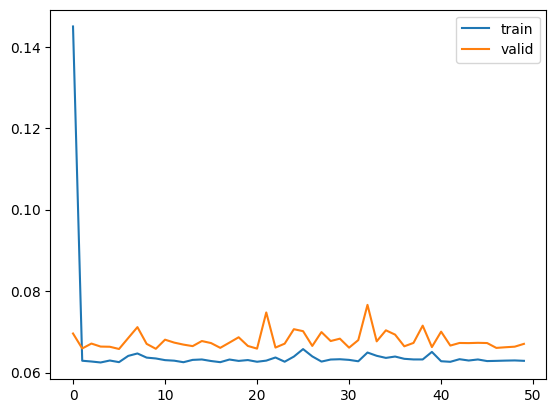

In [318]:
plt.plot(loss_hist_train, label='train')
plt.plot(loss_hist_valid, label='valid')
plt.legend();

torch.Size([12800]) torch.Size([12800])
torch.Size([4000]) torch.Size([4000])
torch.Size([3200]) torch.Size([3200])


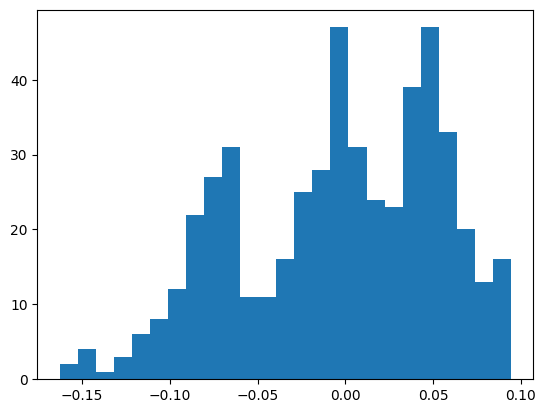

In [10]:
model = FeedForward(input_size=1,output_size=1,n_hidden_layers=1,depht=100).to(device)

noised_data, noise = LoadCSV("noised_data"), LoadCSV("noise")

train_dl, valid_dl, test_dl = Preprocessing(noised_data, noise)

for x_batch, y_batch in train_dl:

  x = x_batch.view(x_batch.size(0), -1).detach().clone().requires_grad_(True)
  y = y_batch.view(y_batch.size(0), -1).detach().clone().requires_grad_(True)

  pred = model(x).to('cpu')

  plt.hist(pred.detach().numpy(),25)

  break